In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import numpy as np
import regex as reg

%matplotlib inline  

Extracting references from texts:

In [ ]:
!python ./Scripts/reference_extraction.py 

Loading references as previously extracted:

In [2]:
references = pd.read_csv('data/References.csv', index_col=0)

references.head()

,ref,file,ref_parsed,pub_year,year,identifier
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,"Lave, J., & Wenger, E. (1991)",2018,1991.0,"Lave, J., & Wenger, E. (1991). Situated learni..."
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2018,2013.0,"Miles, M. B., Huberman, A. M., & Saldana, J. (..."
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",2018,1997.0,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish..."
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,"Rogoff, B. (1995)",2018,1995.0,"Rogoff, B. (1995). Observing sociocultural act..."
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2018,2012.0,"Shirk, J., Ballard, H., Wilderman, C., Phillip..."


Some sample references, and their corresponding identifier:

In [3]:
sample = references[['ref', 'identifier']].sample(4)
_ = [print("Ref: ",r, '\nIdentifier: ', s,) for r, s in zip(sample.ref.tolist(), sample.identifier.tolist())]

Ref:  Clark, L.S. (2013) The parent app. Oxford, United Kingdom: Oxford University Press. 
Identifier:  Clark, L.S. (2013) The parent app
Ref:  Bell, P., Lewenstein, B., Shouse, A. W., & Feder, M. A. (Eds.). (2009). Learning Science in Informal Environments: People, Places, and Pursuits. National Academies Press. 
Identifier:  Bell, P., Lewenstein, B., Shouse, A. W., & Feder, M. A. (Eds.). (2009). Learning Science in Informal Environments: People, Places, and Pursuits
Ref:  Kawasaki, J., Sandoval, W. A., & Rodriguez, L. (2017). Teachers' ideas about teaching the science practices in the next generation science standards. Paper presented at the NARST Annual Meeting, San Antonio, 
Identifier:  Kawasaki, J., Sandoval, W. A., & Rodriguez, L. (2017). Teachers' ideas about teaching the science practices in the next generation science standards
Ref:  Balmaceda, J. M., Schiaffino, S. N., & Pace, J. A. (2014). Using constraint satisfaction to aid group formation in CSCL. Inteligencia Artificial

### Who is cited the most:

First we check over all years:

Scardamalia, M. (2002). Collective cognitive responsibility for the advancement of knowledge                                   32
Lave, J., & Wenger, E. (1991). Situated learning: Legitimate peripheral participation                                          32
Jordan, B., & Henderson, A. (1995). Interaction analysis: Foundations and practice                                             31
Scardamalia, M., & Bereiter, C. (2006). Knowledge building: Theory, pedagogy, and technology                                   23
Papert, S. (1980). Mindstorms: Children, computers, and powerful ideas                                                         20
Barron, B. (2003). When smart groups fail                                                                                      19
Bereiter, C. (2002). Education and mind in the knowledge age                                                                   16
Vygotsky, L. S. (1978). Mind in society: The development of higher psychological processes

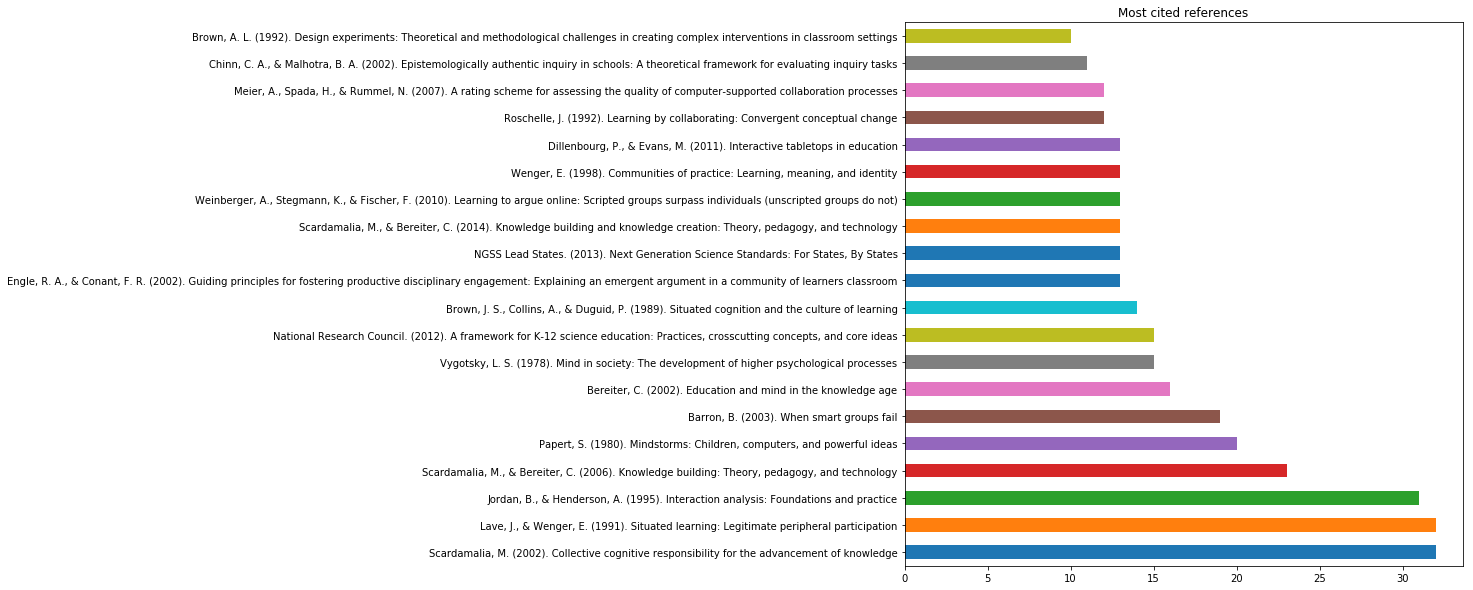

In [4]:
plt.figure(figsize=(10, 10))
plt.title('Most cited references')
references.identifier.value_counts().head(20).plot(kind='barh')
references.identifier.value_counts().head(10)

## Variations in most cited over the years:

Then we look at the different years. A variation over the years could give insights in emerging topics, differences between ICLS and CSCL.

For instance, if we observe the number one most cited text, we see an alternating pattern - maybe those two are very important papers for the two respective conferences!

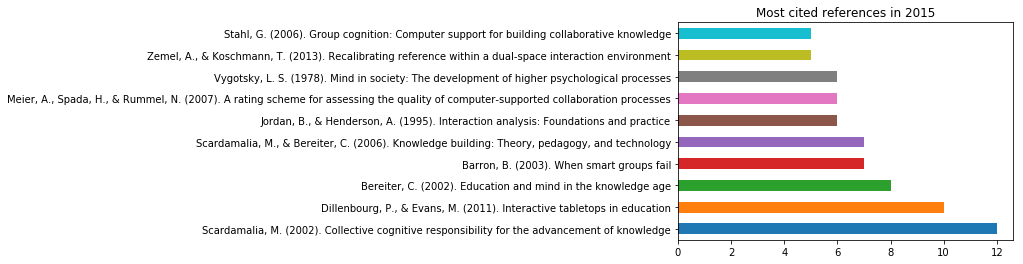

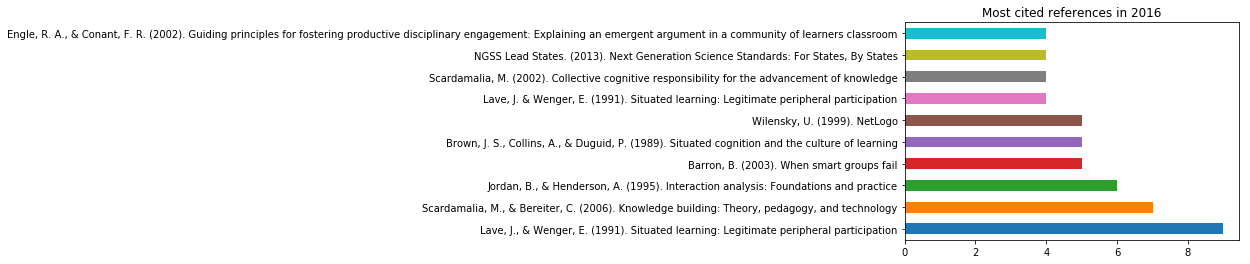

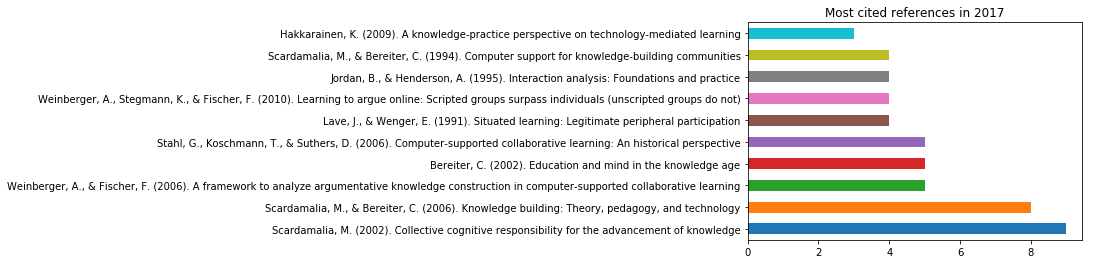

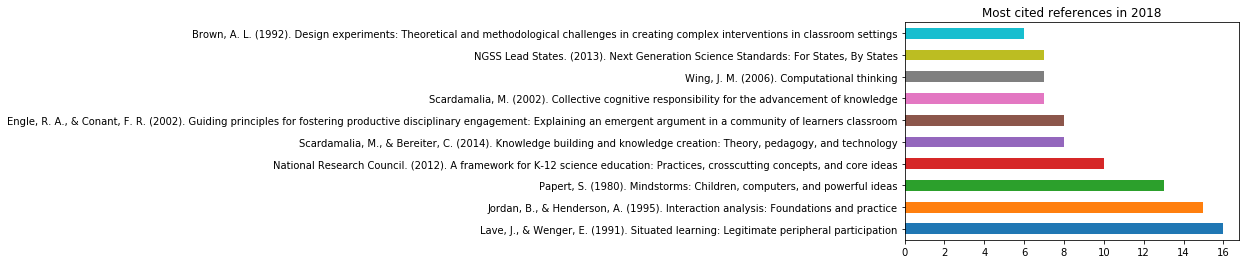

In [5]:
for year in sorted(references.pub_year.unique()):
    plt.title(f'Most cited references in {year}')
    references[references.pub_year == year].identifier.value_counts().head(10).plot(kind='barh')
    plt.show()

### Looking at differences ICLS and CSCL

We decide to look at papers that are cited often and are only cited in ICLS or CSCL (and are cited at those two every year):

In [6]:
d = dict()
for year in sorted(references.pub_year.unique()):
    d[year] = set(references[references.pub_year == year].identifier.value_counts().head(30).index)

In [7]:
ICLS = d[2018].intersection(d[2016])
CSCL = d[2017].intersection(d[2015])

In [8]:
#Even years - odd years 
ICLS - CSCL

{'Barron, B. (2003). When smart groups fail',
 'Brown, J. S., Collins, A., & Duguid, P. (1989). Situated cognition and the culture of learning',
 'Engle, R. A., & Conant, F. R. (2002). Guiding principles for fostering productive disciplinary engagement: Explaining an emergent argument in a community of learners classroom',
 'Lave, J., & Wenger, E. (1991). Situated learning: Legitimate peripheral participation',
 'NGSS Lead States. (2013). Next Generation Science Standards: For States, By States',
 'National Research Council. (2012). A framework for K-12 science education: Practices, crosscutting concepts, and core ideas',
 'Papert, S. (1980). Mindstorms: Children, computers, and powerful ideas',
 'Vygotsky, L. S. (1978). Mind in society: The development of higher psychological processes',
 'Wenger, E. (1998). Communities of practice: Learning, meaning, and identity'}

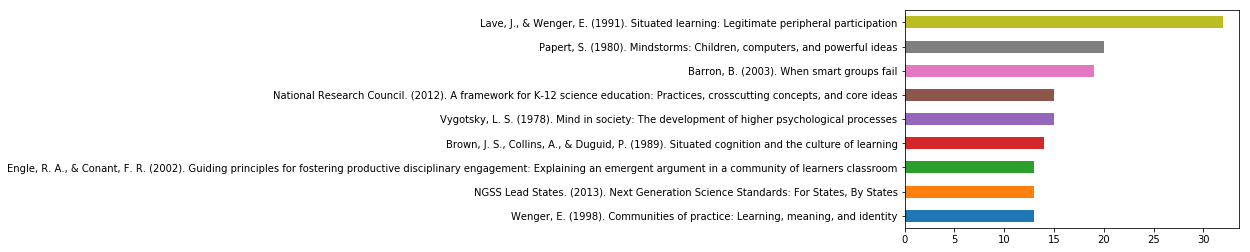

In [9]:
references.identifier.value_counts()[list(ICLS - CSCL)].sort_values().plot(kind='barh')

In [10]:
CSCL - ICLS

{'Bereiter, C. (2002). Education and mind in the knowledge age',
 'Scardamalia, M., & Bereiter, C. (2006). Knowledge building: Theory, pedagogy, and technology'}

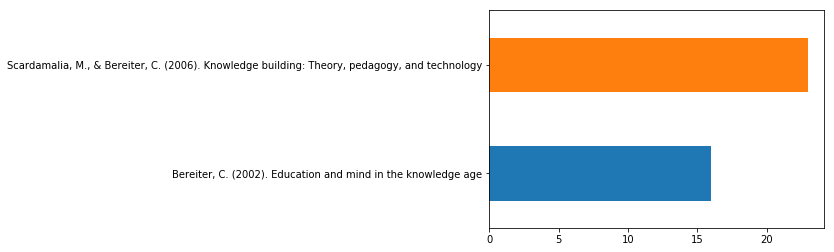

In [11]:
references.identifier.value_counts()[list(CSCL - ICLS)].sort_values().plot(kind='barh')

## We look at how the publication year of  references are distributed:

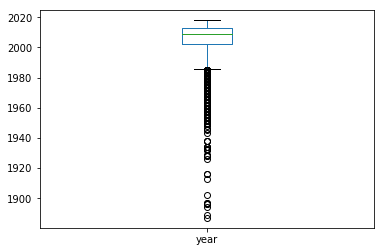

In [12]:
references.year.plot(kind='box')

We don't see much but CSCL has less early (pree 1920) outiers

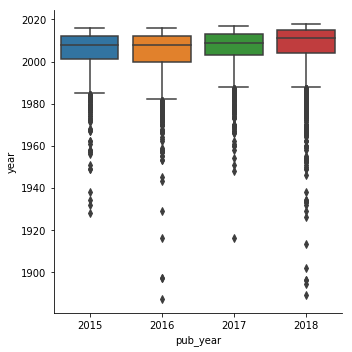

In [13]:
sns.catplot(data=references[['ref','pub_year', 'year']][~references.ref.duplicated()], x='pub_year', y='year', kind='box')

We have an interesting shift to newer sources in 2018:

In [14]:
references[['ref','pub_year', 'year']][~references.ref.duplicated()].groupby('pub_year').year.mean()

pub_year
2015    2004.868721
2016    2004.771092
2017    2006.706161
2018    2007.508080
Name: year, dtype: float64

In [15]:
references[['ref','pub_year', 'year']][~references.ref.duplicated()].groupby('pub_year').year.median()

pub_year
2015    2008.0
2016    2008.0
2017    2009.0
2018    2011.0
Name: year, dtype: float64

## Number of authors in and out of conference being cited

In and out of conference citations, quick calculation:

In [20]:
reference_authors = pd.read_csv('data/Reference_authors.csv', index_col=0)

In [24]:
metadata = pd.read_csv('data/Parsed_metadata.csv')

In [27]:
referenced_authors = set(reference_authors.author.tolist())
authors_in_conf = set(metadata.shortend_names.map(lambda x: x.replace('.', '')))

In [29]:
print('Number of distinct authors of papers in dataset', len(authors_in_conf))
print('Number of distinct cited authors by some author in the conference ', len(referenced_authors))
print('Number of authors that where cited by an other author in the confernce :' , len(referenced_authors.intersection(authors_in_conf)))

Number of distinct authors of papers in dataset 1450
Number of distinct cited authors by some author in the conference  13278
Number of authors that where cited by an other author in the confernce : 793


Example of how one can match the string:

In [30]:
match_conference = ' JLS |Journal of the Learning Sciences|CSCL|ICLS|ijCSCL|Computer(-| |)Supported Collaborative Learning'
re.search(match_conference,'bjfejf ICLS')

<re.Match object; span=(7, 11), match='ICLS'>

Find references belong to conference:

In [34]:
mask_c_s = reference_authors.ref.map(lambda x: True if re.search(match_conference, x) else False)
in_conference = set(reference_authors[mask_c_s].author)

We limit the range of years to get people that are still "active"

In [46]:
not_in_conference = list(set(reference_authors[reference_authors.year > 2010].author) - in_conference.union(authors_in_conf))

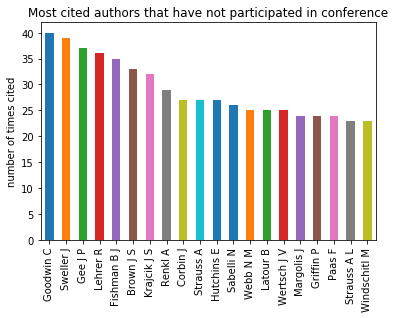

In [59]:
plt.title('Most cited authors that have not participated in conference')
plt.ylabel('number of times cited')
# check that not in conference and is indeed author
is_human = reference_authors.dropna().author.map(lambda x: True if reg.search(r'\p{Lu}$',x) else False)
reference_authors[(reference_authors.author.isin(not_in_conference)) & is_human].author.value_counts().head(20).plot(kind = 'bar')

We again split by years and conference in hopes of detecting a trend over the years or a difference between ICLS and CSCL:

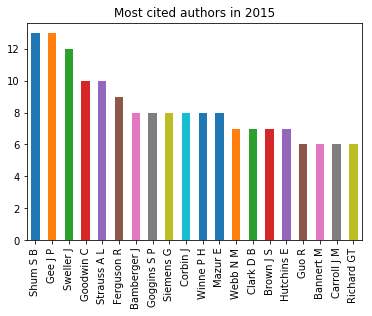

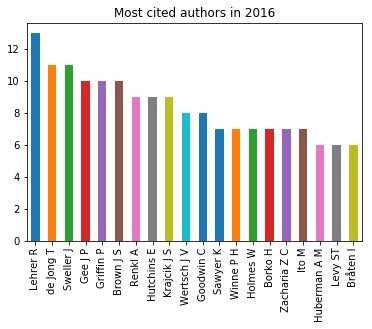

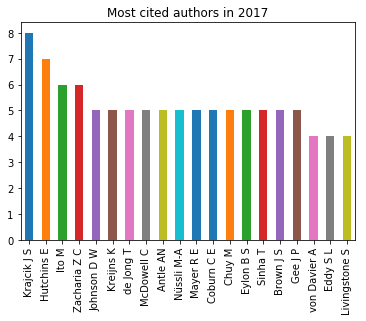

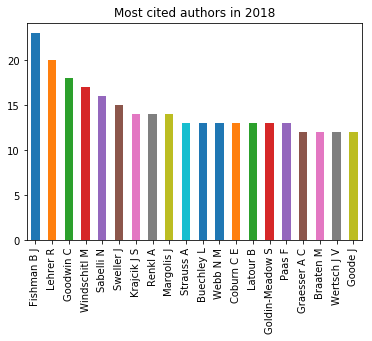

In [65]:
for year in sorted(reference_authors.pub_year.unique()):
    plt.title(f'Most cited authors in {year}')
    reference_authors[(reference_authors.author.isin(not_in_conference)) & is_human & (reference_authors.pub_year == year)
                 ].author.value_counts().head(20).plot(kind = 'bar')
    plt.show()

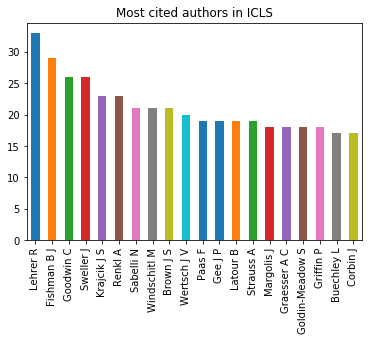

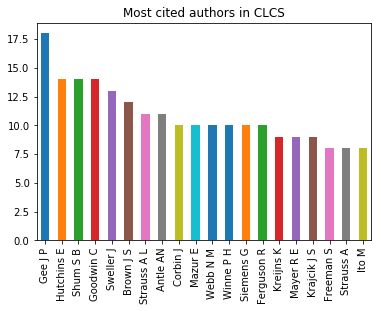

In [66]:
for i, conf in enumerate(['ICLS', 'CLCS']):
    plt.title(f'Most cited authors in {conf}')
    reference_authors[(reference_authors.author.isin(not_in_conference)) & is_human & (reference_authors.pub_year % 2 == i)
                 ].author.value_counts().head(20).plot(kind = 'bar')
    plt.show()

# extracting conference, journal from refrence string

Example of how we can split up the text, which is later used to extract the conference/journal if present:

In [37]:
text = references.sample().ref.item()
split_ref = r'(\.|\?) (?=[\p{Lu}][\p{L}])'
reg.split(split_ref, text)

['Madaio, M. A., Ogan, A., & Cassell, J. (2016)',
 '.',
 'The Effect of Friendship and Tutoring Roles on Reciprocal Peer Tutoring Strategies',
 '.',
 'Intelligent Tutoring Systems Lecture Notes in Computer Science, 423-429.']

We now define a regex that will catch up on words indicating a relation to a conference and then extract and clean the string to get a conference name:

_TODO: include symposium or not?_

In [38]:
#regex to find journals or conferences
pub = '(C|c)onference|(P|p)roceedings|(j|J)ournal|(T|t)ransactions|(s|S)ymposium'
re.search(pub, text)

In [39]:
#set to lower for better matching
match_conference = 'International Conference of (the |)Learning Sciences| JLS |Journal of the Learning Sciences|CSCL|ICLS|ijCSCL|Computer(-| |)Supported Collaborative Learning'
match_conference.lower()

'international conference of (the |)learning sciences| jls |journal of the learning sciences|cscl|icls|ijcscl|computer(-| |)supported collaborative learning'

In [40]:
import nltk
from nltk import word_tokenize
def clean_string(x):
    
    x = x.lower() # lower to ignore case
    
    x = re.sub('[\'\"\”\/\d]*', '', x) #sub out elements that might cause same string to be diff
    x = re.sub(' & ', ' and ', x) # common spelling issue
    x = re.sub(' th | nd | rd | st | volume |—|  |-', ' ', x)
    x = re.sub(' on ', ' of ', x)
    x = x.strip()
    x = ' '.join([ z for z,y in nltk.pos_tag(word_tokenize(x)) if not y in ['CD', ':','$' ]])
    return x

In [41]:
re.search(match_conference.lower(), clean_string('international journal of computer-supported collaborative learning'))

<re.Match object; span=(25, 66), match='computer supported collaborative learning'>

In [42]:
clean_string('international journal of computer-supported collaborative learning')

'international journal of computer supported collaborative learning'

In [43]:
mask = references.ref.map(lambda x: True if 
                          (re.search(pub, x) and not
                          re.search(match_conference.lower(), clean_string(x))) else False)

In [44]:
sources = references[mask].ref.map(lambda x: 
                            [y for y in reg.split(split_ref, x) 
                             if re.search(pub, y)
                            ][0])

In [45]:
sources.shape

(3170,)

Is this CSCL ?

In [67]:
sources[14589]

'In The first international conference on Computer support for collaborative learning (pp. 67-74). L'

In [68]:
sources = sources.map(lambda x: clean_string(x))

In [69]:
def strip_garbage(s):
    r = [y.strip() for y in reg.split(r'\.|\,|\?|\;|\(|\)', s) if re.search(pub.lower(), y)]
    if len(r) > 0:
        return r[0]
    else:
        print(s)
        return None

In [70]:
sources = sources.map(lambda x: strip_garbage(x))#.map(lambda x: x[0] if len(x) > 0 else )

In [71]:
sources.sample(10).tolist()

['journal of research in science teaching',
 'proceedings of educational data mining',
 'in proceedings of tei ’',
 'international journal of designs for learning',
 'calico journal',
 'journal of research in science teaching',
 'in proceedings of the annual conference of the cognitive science society',
 'journal of pragmatics',
 'journal of applied developmental psychology',
 'journal of civil society']

Note: People like to misspell CSCL spell it in various forms..

## Most cited non  CSCL and ISCL conferences:

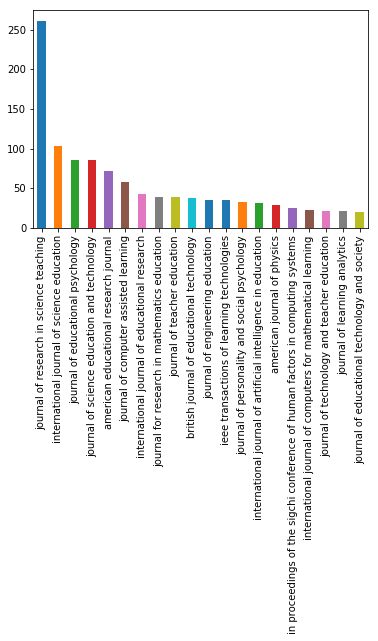

In [72]:
sources.value_counts().head(20).plot(kind='bar')

In [73]:
sources.value_counts().tail(10)

pnas proceedings of the national academy of sciences of the united states of america    1
in international conference of indoor positioning and indoor navigation                 1
journal of contemporary ethnography                                                     1
journal of leadership education                                                         1
proceedings of the eighth international conference of the teaching of statistics        1
in proceedings of the designing interactive systems conference                          1
paper presented at the international conference of intelligent tutoring systems         1
in thirtieth aaai conference of artificial intelligence                                 1
in proceedings of ieee pacific visualization symposium                                  1
in the proceedings of the international conference of intelligent tutoring systems      1
Name: ref, dtype: int64

We analyze how heavy the tail is to find whether we should work on parsing the tail or not:

In [74]:
conference_counts = sources.value_counts()

In [75]:
conference_counts[conference_counts >= 20].sum()

1117

In [76]:
conference_counts[conference_counts < 20].sum()

2053

Conclusion: As the tail accounts for a lage number of conferences better parsing might cause a shift in the most popular conferences. Hence we look into getting more uniform names

A first idea is to look at acronyms..: https://en.wikipedia.org/wiki/List_of_computer_science_conference_acronyms

In [77]:
import urllib3
from bs4 import BeautifulSoup

In [78]:
url = 'https://en.wikipedia.org/wiki/List_of_computer_science_conference_acronyms'
http_pool = urllib3.connection_from_url(url)
r = http_pool.urlopen('GET',url)
data = r.data
soup = BeautifulSoup(data, 'html.parser')
conferences_noisy = soup.find_all('div', class_='mw-parser-output')[0].find_all('li')
abrev_df = pd.DataFrame([c.text.split(' – ') for c in conferences_noisy if reg.search('–', c.text)], columns=['abreviation', 'full_name'])

/anaconda3/envs/Biblio/lib/python3.7/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


The gives us the following list:

In [79]:
abrev_df.head()

,abreviation,full_name
0,AAAI,AAAI Conference on Artificial Intelligence
1,AAMAS,International Conference on Autonomous Agents ...
2,ABZ,International Conference on Abstract State Mac...
3,ACL,Annual Meeting of the Association for Computat...
4,ALGO,ALGO Conference


Constricting regex for easier searching on both columns:

In [80]:
conf_regex = ' | '.join(abrev_df.abreviation.map(lambda x: x.lower()).tolist())
conf_regex

'aaai | aamas | abz | acl | algo | amcis | ants | ares | asiacrypt | asp-dac | ase | aswec | atmos | cade | cav | cc | ccsc | ches | chi | ciaa | cibb | cicling | cidr | cikm | crypto | cusec | cvpr | dac | date | dcfs | disc | dlt | dsn | ecai | ecco | ecis | ecml pkdd | ecoop | ecss | esa | esop | eswc | etaps | eurocrypt | eurographics | ewsn | fase | fast | fcrc | floc | focs | forte | fossacs | fse | ftp | gd | globecom | graphicon | hicss | hipc | hopl | hot interconnects | icalp | icassp | iccad | icc | iccit | iccv | icdcs | icfp | icis | icl | iclp | icml | icpads | icse | icsoc | icsr | icter | icws | ijcai | ijcar | ijcbs | indocrypt | ipdps | ipsn | isaac | isca | iscas | ismar | iswc | ispd | isscc | iswc | kdd | lics | lrec | mm | mobicom | mobihoc | mobilehci | naacl | nips | nime | oopsla | pacis | pimrc | pkc | pkdd | pldi | plop | podc | pods | popl | post | ppopp | psb | recomb | rev | rsa | rta | sac | sac | same | seams | sefm | sensys | sigcomm | sigcse | sigdoc |

In [81]:
sources.map(lambda x: True if reg.search(conf_regex, x) else False).sum()

36

In [82]:
references.ref.map(lambda x: reg.search(conf_regex, x.lower()).group(0) if reg.search(conf_regex, x.lower()) else None).dropna().value_counts()

 sigcse       29
 chi          28
aaai           7
 nips          5
 fast          5
 same          5
 siggraph      2
 post          2
 cicling       2
 www           2
 zum           2
 acl           2
 wine          1
 sigir         1
 hicss         1
 kdd           1
 usenix        1
 ijcai         1
 sigdoc        1
 vis           1
 iswc          1
Name: ref, dtype: int64

In [83]:
conf_regex = ' |'.join(abrev_df.full_name.map(lambda x: x.lower()).tolist())

In [84]:
references.ref.map(lambda x: reg.search(conf_regex, x.lower()).group(0) if reg.search(conf_regex, x.lower()) else None).dropna().value_counts()

acm technical symposium on computer science education         19
acm conference on human factors in computing systems           8
international symposium on wearable computers                  2
conference on information and knowledge management             2
international joint conference on artificial intelligence      2
international conference on software engineering               1
acm international conference on design of communication        1
aaai conference on artificial intelligence                     1
international symposium on wikis and open collaboration        1
annual international acm sigir conference                      1
international conference on distributed computing systems      1
world wide web conference                                      1
Name: ref, dtype: int64

We see that this doesn't add tooo much information, but it also indicates that people don't really seem to cute much form computer science conferences

### Other conferences

And other idea is to look at non enlish words that come up often, they might be conference names!

In [85]:
import enchant
#check if a word is english
d = enchant.Dict("en_US")

In [86]:
#some issues but works well
d.check("online")

False

In [87]:
potential_abv = [word[0].upper()+word[1:] for sentence in sources.map(lambda x: word_tokenize(x)).tolist() for word in sentence if not d.check(word)]

In [88]:
pd.Series([p for p in potential_abv if not d.check(p) and len(p) > 2 and len(p) < 6]).value_counts().head(20)

Acm      138
Ieee      85
Idc       18
Pre       16
Lak       14
Asee      10
Cscw       8
Icer       8
Aaai       4
Aied       3
Igpme      3
Edm        3
Intl       3
Bcs        3
Earli      3
Icmi       3
Sotl       2
Zdm        2
Nas        2
Http       2
dtype: int64

### Looking at the question of creating more uniform names:

We use a similarity measure:

This works somewhat okay, but probably not worth the effort given that this doesn't make sigchi and  ... computer human interaction the same conference

In [89]:
import difflib
difflib.SequenceMatcher(None, 'hello', 'helo').ratio()

0.8888888888888888

In [90]:
d = {}

In [91]:
for i, row in enumerate(sources.unique()):
    for j, row_2 in enumerate(sources.unique()):
        if i > j and row != row_2:
            difference = difflib.SequenceMatcher(None, row, row_2).ratio()
            if difference > 0.9:
                if not row_2 in d.keys():
                    d[row_2] = row

In [92]:
len(d)

223

As everything is fairly regular, maybe rake can give us some titles? -> pretty much the same as we get anyway -> irregular titles are really just infequent

In [93]:
import rake
import operator

In [94]:
rake_object = rake.Rake("data/SmartStoplist.txt", 26, 10, 10)
keywords = rake_object.run(' . '.join(sources.tolist()))
keywords

[('sigchi conference of human factors in computing systems',
  54.123946851301206),
 ('acm conference of computer supported cooperative work', 44.935864777225866),
 ('acm technical symposium of computer science education', 42.35980681739533),
 ('journal of pre college engineering education research', 40.135182356284375),
 ('journal of research of technology in education', 39.16928709678454),
 ('conference of interaction design and children', 35.2335332858237),
 ('conference of learning analytics and knowledge', 34.97767513845663),
 ('journal of adolescent and adult literacy', 34.58936033874355),
 ('journal of artificial intelligence in education', 34.283014985822845),
 ('journal for research in mathematics education', 34.27898498777122),
 ('journal of research in science teaching', 34.15059196554651),
 ('journal of computers for mathematical learning', 33.97494871788647),
 ('journal of technology and design education', 33.9413210146235),
 ('journal of science education and technology',

## Again looking at the difference between CSCL and ICLS - outside citations:

In [95]:
references['conference'] = sources

In [96]:
references['cited_in'] = references.file.map(lambda x: int(re.search('[\d]{4}',x).group(0)))

In [97]:
references.head()

,ref,file,ref_parsed,pub_year,year,identifier,conference,cited_in
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,"Lave, J., & Wenger, E. (1991)",2018,1991.0,"Lave, J., & Wenger, E. (1991). Situated learni...",NaN,2018
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2018,2013.0,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",NaN,2018
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",2018,1997.0,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",NaN,2018
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,"Rogoff, B. (1995)",2018,1995.0,"Rogoff, B. (1995). Observing sociocultural act...",NaN,2018
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2018,2012.0,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",NaN,2018


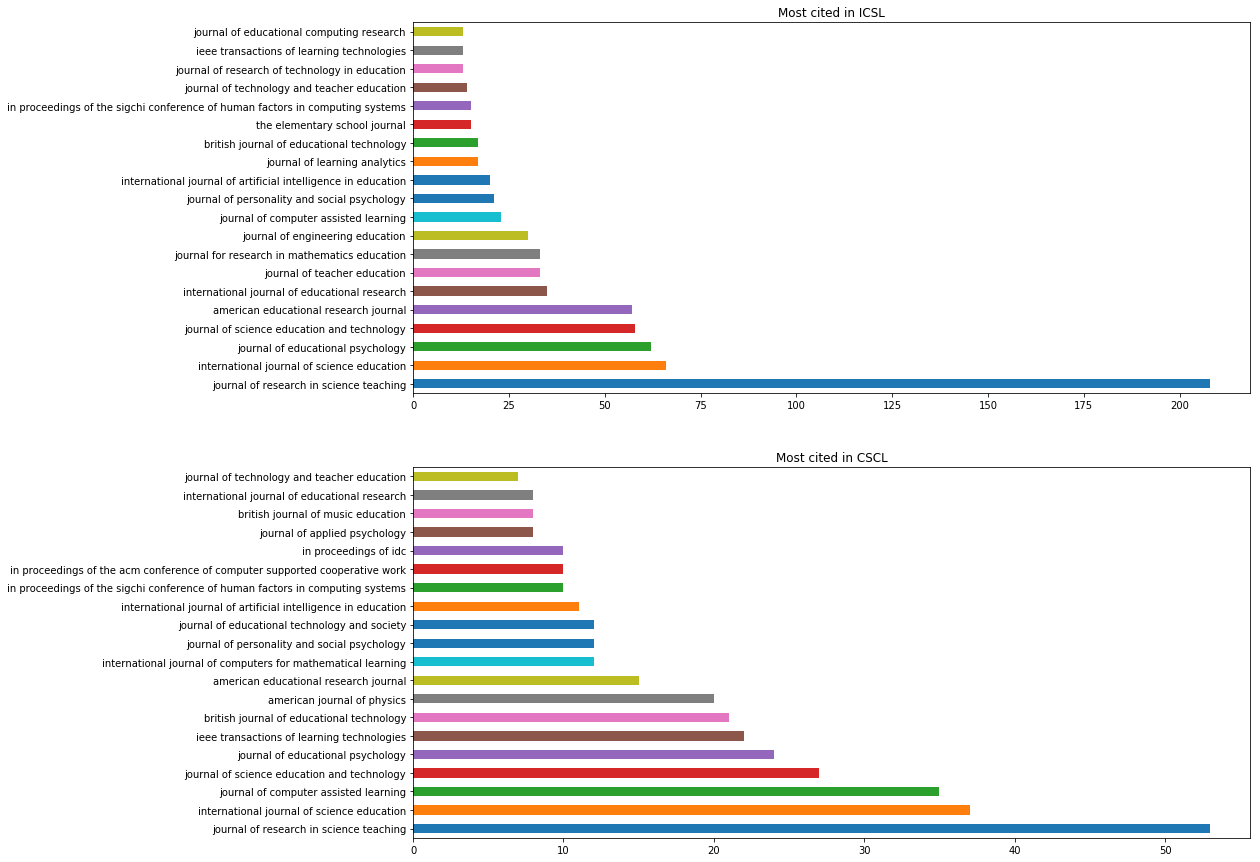

In [109]:
plt.figure(figsize=(15, 15))

plt.subplot(211)
plt.title('Most cited in ICSL')
references[references.cited_in % 2 == 0].conference.value_counts().head(20).plot(kind='barh')

plt.subplot(212)
plt.title('Most cited in CSCL')
references[references.cited_in % 2 == 1].conference.value_counts().head(20).plot(kind='barh')

Top 20 Conferences in both

In [99]:
set(references[references.cited_in % 2 == 0].conference.value_counts().head(20).index).intersection(set(references[references.cited_in % 2 == 1].conference.value_counts().head(20).index))

{'american educational research journal',
 'british journal of educational technology',
 'ieee transactions of learning technologies',
 'in proceedings of the sigchi conference of human factors in computing systems',
 'international journal of artificial intelligence in education',
 'international journal of educational research',
 'international journal of science education',
 'journal of computer assisted learning',
 'journal of educational psychology',
 'journal of personality and social psychology',
 'journal of research in science teaching',
 'journal of science education and technology',
 'journal of technology and teacher education'}

Conferences in top twenty of ICLS and not CSCL

In [100]:
set(references[references.cited_in % 2 == 0].conference.value_counts().head(20).index) - set(references[references.cited_in % 2 == 1].conference.value_counts().head(20).index)

{'journal for research in mathematics education',
 'journal of educational computing research',
 'journal of engineering education',
 'journal of learning analytics',
 'journal of research of technology in education',
 'journal of teacher education',
 'the elementary school journal'}

In [104]:
top_50 = set(references[references.cited_in % 2 == 0].conference.value_counts().head(50).index) - set(references[references.cited_in % 2 == 1].conference.value_counts().head(50).index)
top_50

{'acm transactions of computing education',
 'australasian journal of educational technology',
 'british educational research journal',
 'european journal of social psychology',
 'in proceedings of the annual acm conference of human factors in computing systems',
 'in proceedings of the chi conference of human factors in computing systems',
 'in proceedings of the international conference of interaction design and children',
 'in proceedings of the sixth international conference of learning analytics and knowledge',
 'international journal of designs for learning',
 'international journal of engineering education',
 'international journal of human computer studies',
 'international journal of learning and media',
 'international journal of technology and design education',
 'journal of adolescent and adult literacy',
 'journal of chemical education',
 'journal of curriculum studies',
 'journal of educational change',
 'journal of experimental child psychology',
 'journal of pre college

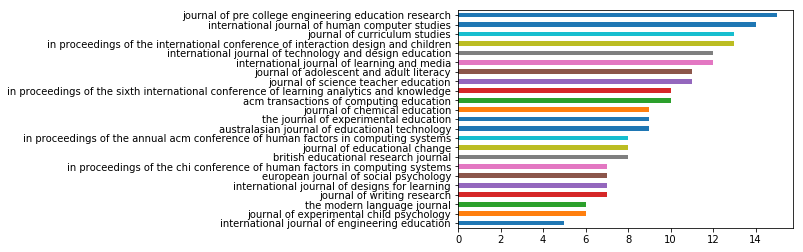

In [113]:
references[references.conference.isin(top_50)].conference.value_counts().sort_values(ascending=True).plot(kind='barh')

Conferences in top twenty of CSCL and not ICLS

In [102]:
set(references[references.cited_in % 2 == 1].conference.value_counts().head(20).index) - set(references[references.cited_in % 2 == 0].conference.value_counts().head(20).index)

{'american journal of physics',
 'british journal of music education',
 'in proceedings of idc',
 'in proceedings of the acm conference of computer supported cooperative work',
 'international journal of computers for mathematical learning',
 'journal of applied psychology',
 'journal of educational technology and society'}

In [114]:
top_50 = set(references[references.cited_in % 2 == 1].conference.value_counts().head(50).index) - set(references[references.cited_in % 2 == 0].conference.value_counts().head(50).index)
top_50

{'american journal of sociology',
 'british journal of music education',
 'canadian journal of learning and technology',
 'ieee transactions of education',
 'ieee transactions on',
 'in proceedings of idc',
 'in proceedings of the acm conference of computer supported cooperative work',
 'in proceedings of the asee annual conference',
 'in proceedings of the conference of human factors in computing systems',
 'in proceedings of the international conference of international conference for the learning sciences volume',
 'in proceedings of the third international conference of learning analytics and knowledge',
 'in world conference of educational multimedia',
 'international journal of artificial intelligence and education',
 'international journal of technology enhanced learning',
 'journal of applied psychology',
 'journal of artificial societies and social simulation',
 'journal of asynchronous learning networks',
 'journal of computer mediated communication',
 'journal of computing s

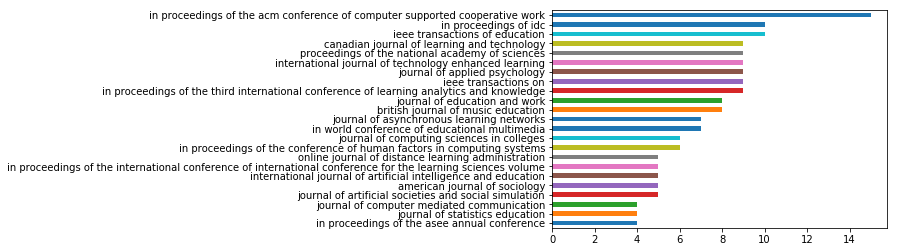

In [115]:
references[references.conference.isin(top_50)].conference.value_counts().sort_values(ascending=True).plot(kind='barh')